# 2022/01/07/FRI

> ### ***`Random Forest`***
 배깅은 앞서 소개한 보팅과는 달리 같은 알고리즘으로 여러 개의 분류기를 만들어서 보팅으로 최종 결정하는 알고리즘이다. 그 중 랜덤 포레스트의 기반 알고리즘은 결정 트리이다. 
 개별 트리가 학습하는 데이터 세트는 전체 데이터 세트에서 일부가 중첩되게 샘플링된 데이터 세트이다.
 이렇게 여러 개의 데이터 세트를 중첩되게 분리하는 것을 부트스트래핑 분할 방식이라 한다. 이때 서브 데이터 건수는 전체 데이터 건수와 동일(218p참고),사이킷런은 RandomForestClassifier 클래스를 통해 랜덤 포레스트 기반의 분류를 지원한다. 

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

def get_new_feature_name_df(old_feature_name_df):
    #column_name으로 중복된 컬럼명에 대해서는 중복 차수 부여, col1, col1과 같이 2개의 중복 컬럼이 있을 경우 1, 2 
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    # feature_dup_df의 index인 column_name을 reset_index()를 이용하여 컬럼으로 변환. 
    feature_dup_df = feature_dup_df.reset_index()
    # 인자로 받은 features_txt의 컬럼명 DataFrame과 feature_dup_df를 조인. 
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    # 새로운 컬럼명은 앞에 중복 차수를 접미어로 결합. 
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

# 결정 트리에서 사용한 get_human_dataset( )을 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 셋으로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train , y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test , pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


---

> GridSearchCV를 이용해 랜덤 포레스트의 하이퍼 파라미터를 튜닝해보자

In [13]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12], 
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}
# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state=0, n_jobs=-1)
grid_cv = GridSearchCV(rf_clf , param_grid=params , cv=2, n_jobs=-1 )
grid_cv.fit(X_train , y_train)

print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

최적 하이퍼 파라미터:
 {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


- n_estimators를 300으로 증가시키고, 최적화 하이퍼 파라미터로 다시 RandomForestClassifier를 학습시킨 뒤 이번에는 별도의 데이터 테스트 세트에서 예측을 수행해보자

In [14]:
rf_clf1 = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_leaf=8, \
                                 min_samples_split=8, random_state=0)
rf_clf1.fit(X_train , y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test , pred)))

예측 정확도: 0.9165


- feature_importances_를 이용해 알고리즘이 선택한 feature의 중요도를 알아보자

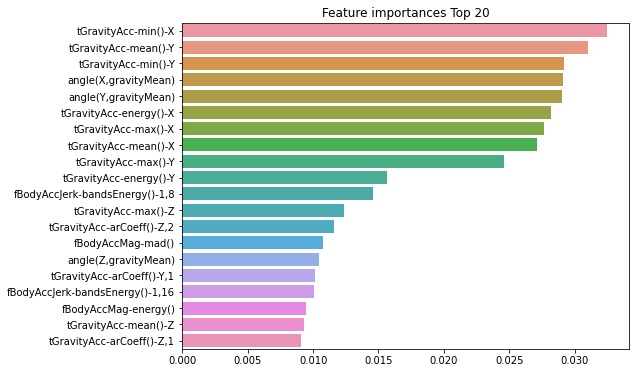

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns  )
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20 , y = ftr_top20.index)
plt.show()

> ### ***`GBM(Gradient Boosting Machine)`***
 부스팅 알고리즘은 여러 개의 약한 학습기를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식이다. 부스팅의 대표적인 구현은 AdaBoost(Adaptive boosting)와 그래디언트 부스트가 있다. 에이다 부스트는 오류 데이터에 가중치를 부여하면서 부스팅을 수행하는 대표적인 알고리즘이다. (223p의 그림을 통해 에이다 부스트의 진행 과정에 대해 알아보자) 예를 들어 첫번째 약한 학습기는 가중치 0.3을 부여하며, 두번째 학습기는 가중치 0.5 이런 식으로 가중치를 늘려가며 학습을 진행한다.
 

GBM도 에이다 부스트와 유사하나 가중치 업데이트를 경사 하강법(Gradient Descent)을 이용한다. 
오류값은 실제 값-예측 값이며, 이 오류값을 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트 하는 것이 경사하강법이다.

사이킷런은 GBM 기반의 분류를 위해서 GradientBoostingClassifier클래스를 제공.

In [7]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정.
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train , y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초 ".format(time.time() - start_time))

GBM 정확도: 0.9389
GBM 수행 시간: 508.8 초 


8분이나 걸렸음 ;

(트리 기반 자체의 파라미터더 동일하게 적용되며, GBM에서 사용하는 하이퍼 파라미터 및 튜닝에 대해 225p 참고)

GridSearchCV를 이용해 하이퍼 파라미터를 최적화해보자. 다만 꽤 오랜 시간이 걸릴 것으로 예상되어 markdown처리 하겠다.

```python
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100, 500],
    'learning_rate' : [ 0.05, 0.1]
}
grid_cv = GridSearchCV(gb_clf , param_grid=params , cv=2 ,verbose=1)
grid_cv.fit(X_train , y_train)
print('최적 하이퍼 파라미터:\n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))
```

이 설정을 그대로 테스트 데이터 세트에 적용해 예측 정확도를 확인해보자. 동일하게 markdown처리 하겠음

```python
# GridSearchCV를 이용하여 최적으로 학습된 estimator로 predict 수행. 
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
```

이처럼 GBM은 과적합에도 강한 뛰어난 예측성능을 가진 알고리즘이지만 수행 시간이 오래 걸린다. 

이제 머신러닝 세계에서 가장 각광 받고 있는 두 개의 그래디언트 부스팅 기반 패키지에 대해 알아보자

----

> ### ***`XGBoost`***
 트리 기반임. 분류에 있어서 일반적으로 다른 머신러닝보다 뛰어난 예측성능을 나타낸다. GBM에 기반하지만 더울 빠른 수행 시간 및 과적합 규제 부재 등의 문제를 해결해 각광받음. 병렬 CPU환경에서 병렬학습이 가능해 수행시간 UP,다만 일반적인 GBM에 비해 빠르다는 것이지 다른 머신러닝 알고리즘(예를 들어 랜덤 포레스트)에 비해 빠르다는 것은 아니다. 

> 파이썬 래퍼 XGBoost를 적용하여 위스콘신 유방암을 예측해보자
 XGBoost의 파이썬 패키지인 xgboost는 자체적으로 교차 검증, 성능 평가, feature중요도등의 시각화 기능이 있음. 또한 조기 중단 기능이 있어 num_rounds로 지정한 부스팅 반복 횟수에 도달하지 않더라도 더 이상 예측 오류가 개선되지 않으면 반복을 끝까지 수행하지 않고 중지해 수행시간을 개선할 수 있음.

In [3]:
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


- 종양의 크기와 모양에 관한 많은 속성이 숫자형 값으로 돼 있음. 맨 마지막 column인 target label값의 종류는 악성인 'malignant'가 0값으로 양성인'benign'이 1값으로 돼있음.

In [5]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


- 전체 데이터 세트 중 80%를 학습용으로 20%를 테스트 용으로 분할해보자

In [6]:
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )
print(X_train.shape , X_test.shape)

(455, 30) (114, 30)


- 파이썬 래퍼 XGBoost는 사이킷런과 여러 차이가 있지만 눈에 띄는 차이는 학습용 테스트용 데이터 세트를 위해 별도의 객체인 DMatrix를 생성한다는 점이다. DMatrix는 주로 넘파이 입력 파라미터를 받아서 만들어지는 XGBoost만의 전용 데이터 세트이다. 

In [7]:
dtrain = xgb.DMatrix(data=X_train , label=y_train)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [8]:
params = { 'max_depth':3,
           'eta': 0.1,
           'objective':'binary:logistic',
           'eval_metric':'logloss',
           'early_stoppings':100
        }
num_rounds = 400

이제 지정된 하이퍼 파라미터로 XGBoost 모델을 학습시켜보자

```python
# train 데이터 셋은 ‘train’ , evaluation(test) 데이터 셋은 ‘eval’ 로 명기합니다. 
wlist = [(dtrain,'train'),(dtest,'eval') ]
# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtrain , num_boost_round=num_rounds , evals=wlist )
```

train()으로 학습을 수행하면 반복 시 train-error와 eval_logloss가 지속적으로 감소함. xgboost를 이용해 모델의 학습이 완료됐으면 이를 이용해 테스트 데이터 세트에 예측을 수행.

In [10]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [18]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [20]:
# get_clf_eval(y_test , preds, pred_probs)

xgboost 패키지에 내장된 시각화 기능을 수행해보자

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

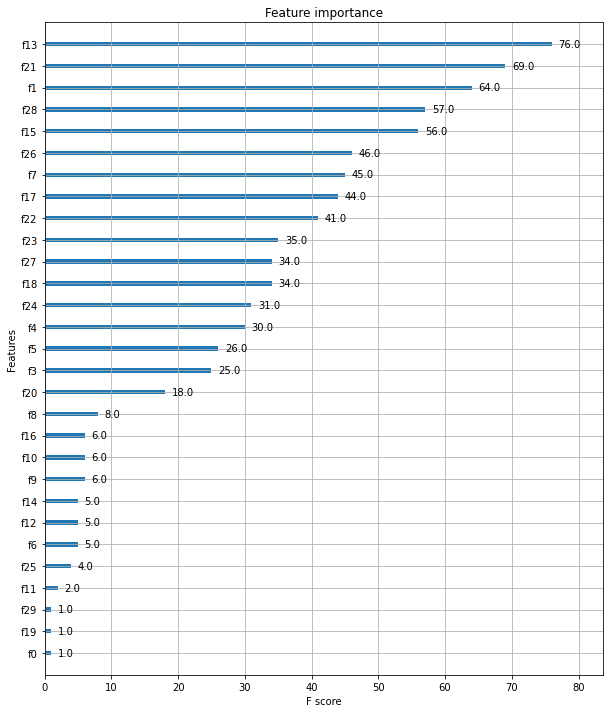

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

파이썬 래퍼 XGBoost는 사이킷런의 GridSearchCV와 유사하게 데이터 세트에 대한 교차 검증 수행 후 최적 파라미터를 구할 수 있는 방법을 cv() API로 제공.
xgb.cv의 반환값은 DataFrame 형태임.

XGBoost를 위한 사이킷런 래퍼는 사이킷런과 호환돼 편리하게 사용할 수 있기 때문에 앞으로는 파이썬 래퍼XGBoost가 아닌 사이킷런 래퍼 XGBoost를 사용하겠음

 XGBoost는 크게 분류를 위한 XGBClassifier, 회귀를 위한 래퍼 클래스인 XGBRegressor가 있음

In [24]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train , y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[12:59:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [26]:
# get_clf_eval(y_test , w_preds, w_pred_proba)

앞 예제의 파이썬 래퍼 XGBoost와 동일한 평가 결과가 나옴을 알 수 있다. 사이킷런 래퍼 XGBoost에서도 조기 중단을 수행할 수 있다. 조기 중단 관련 파라미터를 fit()에 입력하면 된다.


```python
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)

evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
```

n_estimator를 400으로 설정해도 400번 수행하지 않고 311번 반복한 후 학습을 완료함. (211번에서 311번까지 early_stopping_rounds=100으로 지정된 100번의 반복 동안 성능 평가 지수가 향상되지 않았기 때문에)

```python
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)
```

조기 중단이 적용되지 않은 결과보다 약간 저조한 성능을 나타냈지만, 큰 차이는 아님

조기 중단값을 너무 급격하게 줄이면 예측 성능이 저하될 우려가 크다. 만일 early_stopping_rounds를 10으로 하면 아직 성능이 향상될 여지가 있음에도 불구하고 10번 반복하는 동안 성능 평가 지표가 향상디지 않으면 반복이 멈춰 버려서 충분한 학습이 되지 않아 예측 성능이 나빠질 수 있다. 

- feature의 중요도를 시각화하는 모듈인 plot_importance() API에 사이킷런 래퍼 클래스를 입력해도 앞에서 파이썬 래퍼 클래스를 입력한 결과와 똑같이 시각화 결과를 얻을 수 있음

```python
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)
```

그림이 상당히 지저분해서 markdown처리 하겠음